Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=   0.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=   0.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=   0.0s
[CV] END ..........alpha=0.001, l1_ratio=0.30000000000000004; total time=   0.0s
[CV] END ..........alpha=0.001, l1_ratio=0.30000000000000004; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=   0.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.4; total time=   0.0s
[CV] END ..........alpha=0.001, l1_ratio=0.30000000000000004; total time=   0.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.4; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=0.5; total time=   0.0s
[CV] END ..........................alpha=0.001,

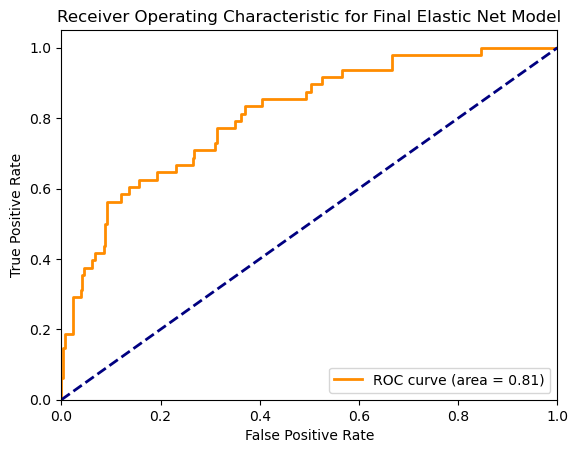

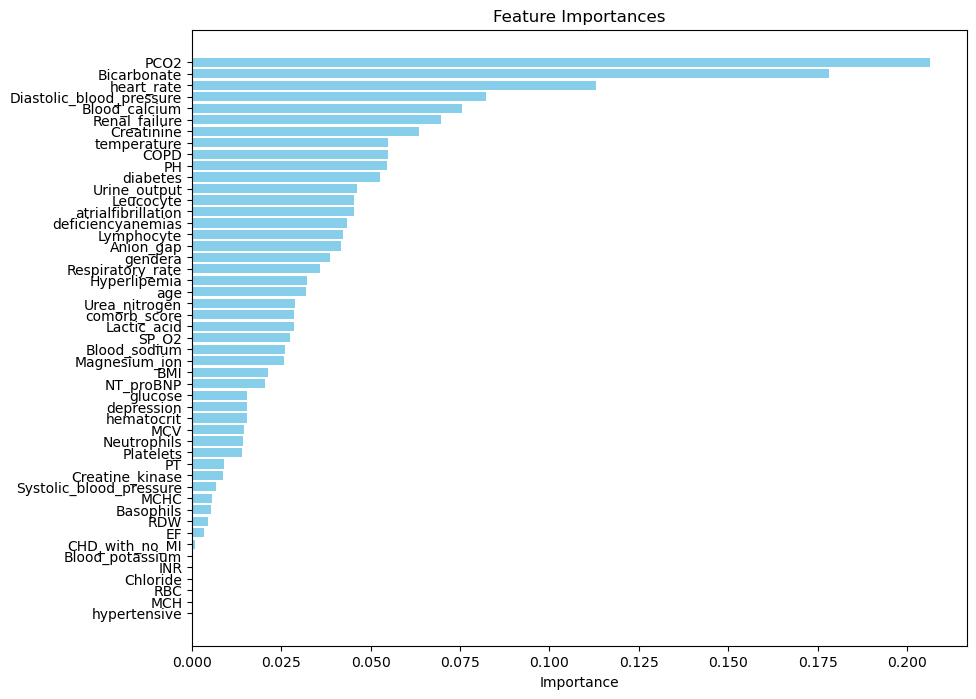

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed, stratify=data['outcome'])
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Elastic Net model
enet = ElasticNet(max_iter=100000)

# Define the hyperparameters to tune
param_grid = {
    'alpha': np.logspace(-3, 2, 10),  # More refined alpha range
    'l1_ratio': np.linspace(0.1, 0.9, 9)  # Exclude 0 to avoid Ridge-specific cases
}

# Perform GridSearchCV with stratified K-Folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=enet, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_enet = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

# Train the final model with the best hyperparameters
best_enet.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
y_pred_proba_final = best_enet.predict(X_valid)
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print(classification_report(y_valid, y_pred_final, zero_division=0))

# Calculate AUC for the final model
auc_final = roc_auc_score(y_valid, y_pred_proba_final)
print(f"Final AUC: {auc_final}")

# Plot ROC curve for the final model
fpr_final, tpr_final, thresholds_final = roc_curve(y_valid, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {auc_final:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Final Elastic Net Model')
plt.legend(loc="lower right")
plt.show()

# Calculate feature importances
coefficients = best_enet.coef_
features = predictor_names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


### bayesian lasso

In [18]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed)
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define Bayesian Lasso model using Functional API
def build_bayesian_lasso_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    dense_variational = tfp.layers.DenseVariational(
        units=1,
        make_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        make_prior_fn=tfp.layers.default_multivariate_normal_fn,
        kl_weight=1/X_train_resampled.shape[0]
    )(inputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=dense_variational)
    
    def neg_log_likelihood(y_true, y_pred):
        return -tf.reduce_mean(y_pred.log_prob(y_true))
    
    model.compile(optimizer=tf.optimizers.Adam(), loss=neg_log_likelihood)
    
    return model

num_features = X_train_resampled.shape[1]
model = build_bayesian_lasso_model((num_features,))

# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=500, verbose=False)

# Evaluate the model
y_pred_proba = model.predict(X_valid)
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_valid, y_pred, zero_division=0))

# Calculate AUC for the model
auc = roc_auc_score(y_valid, y_pred_proba)
print(f"AUC: {auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Bayesian Lasso Model')
plt.legend(loc="lower right")
plt.show()


AttributeError: 'tuple' object has no attribute 'rank'